In [ ]:
import sys

sys.path.append("..")

import os
from create_dataset import CreateSegmentationDataset, get_labels_dict
from segment.utils import get_device
from datasets import load_dataset
from create_dataset import filter_list_in_column
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

# disable datasets.map progress bar
from datasets.utils.logging import disable_progress_bar

os.environ["TOKENIZERS_PARALLELISM"] = "false"

disable_progress_bar()

# The number of images loaded on each batch
batch_size = 64

# The number of images processed on the gpu
sub_batch_size = 8

# The number of workers for the dataloader
num_workers = os.cpu_count() 

# The directory for hugging face cache
cache_dir = "hf_cache"

# The image dataset ID and split to load
dataset_id = "MnLgt/fashion_people_detections"

split = "train"

# The repo to push the dataset to
push_to_repo_id = "MnLgt/fashion_people_detections_test"
token = os.getenv("HUGGINGFACEHUB_API_TOKEN")

# The labels from the yolo config file
config_path = "configs/fashion_people_detection_no_person.yml"

# Thresholds for dino and sam
box_threshold = 0.3
iou_threshold = 0.8
text_threshold = 0.35

In [ ]:

ds = load_dataset(
    dataset_id,
    split=split,
    trust_remote_code=True,
    cache_dir=cache_dir,
    streaming=False,
    num_proc=num_workers,
)
print(f"Total Rows: {ds.num_rows}")

# Filter for images with one person
a = ds["num_people"]
b = [i for i, x in enumerate(a) if x > 0]
c = ds.select(b)
ds = c

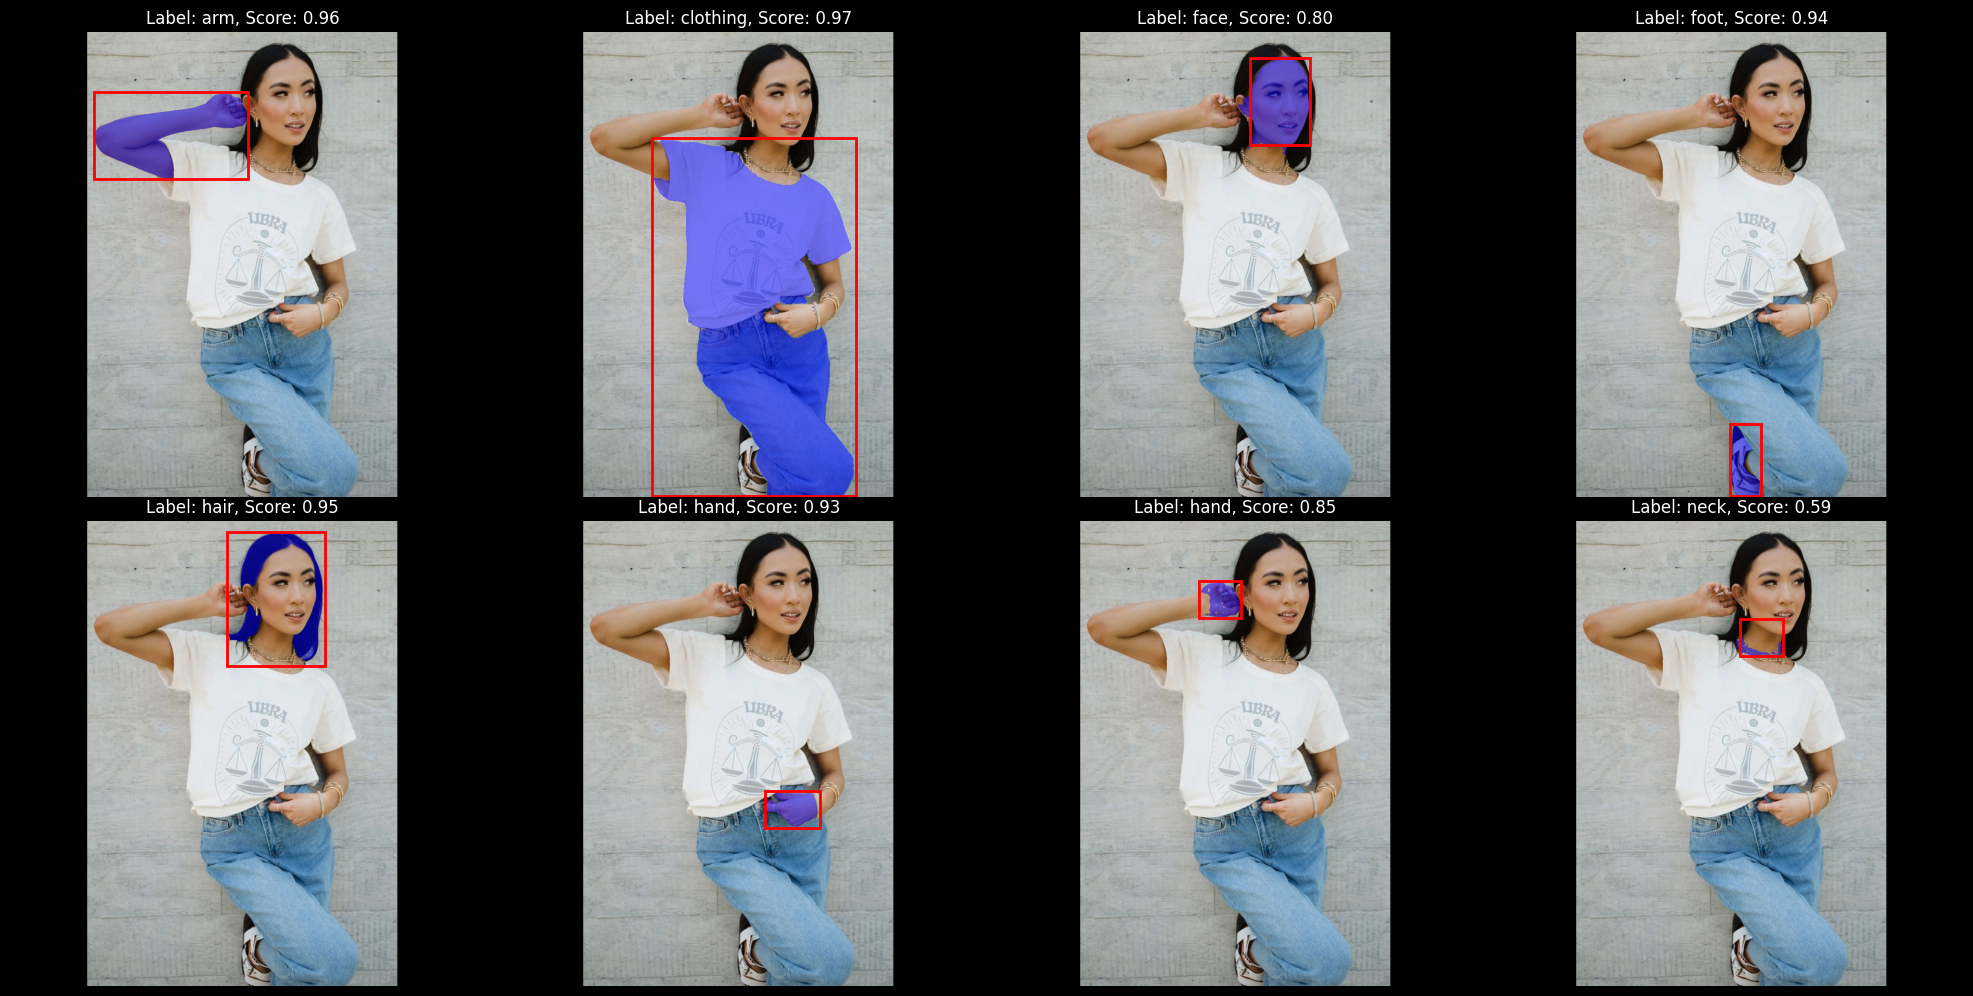

In [36]:
# item = 1136

# row = ds.__getitem__(item)
# from segment.dino_script import DinoDetector
# from segment.sam_script import get_sam_results
# from segment.sam_results import SAMResults

# text_prompt = ["hair", "face", "neck", "arm", "hand", "back", "leg", "clothing", "phone", "hat", "foot"]

# text_prompt = ".".join(text_prompt)
# labels_dict = {prompt.strip(): idx for idx, prompt in enumerate(text_prompt.split("."))}

# detector = DinoDetector(row['image'],text_prompt)
# detector.run()
# unformatted_results = get_sam_results(detector.images, boxes=detector.boxes, phrases=detector.pred_prompt)


# sr = SAMResults(detector.images[0], **unformatted_results[0], labels_dict=labels_dict,person_masks_only=False)
# sr.display_results(prompt_label="label")

In [ ]:

p = CreateSegmentationDataset(
    ds,
    config_path,
    bs=batch_size,
    sub_bs=sub_batch_size,
    box_threshold=box_threshold,
    text_threshold=text_threshold,
    iou_threshold=iou_threshold,
)

p.process()

# remove any items from the md lists that are empty
def remove_none(item):
    return bool(item)

p.processed_ds = filter_list_in_column(p.processed_ds, "metadata", remove_none)

# filter items with a score
p.filter_scores(score_cutoff=0.8)

# remove the original mask_metadata column
p.processed_ds = p.processed_ds.remove_columns("mask_metadata")

p.push_to_hub(repo_id=push_to_repo_id, token=token, private=False)


In [ ]:
p.check_results()